# Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
rows = 50000

In [3]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1', nrows = rows)
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1', nrows = rows)
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [4]:
dfnlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [5]:
print(dfnlp.shape)
print(dfppro.shape)

(50000, 21)
(50000, 17)


In [6]:
dfppro.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


# Have to combine these 2 dfs first So that later we can add just one tfidf vector for questions via hstack
# As question1 and ques2 are preprocessed in dfnlp then we must vectorize with dfnlp questions

In [7]:
dfppro = dfppro.drop(['qid1', 'qid2', 'question1', 'question2','is_duplicate'], axis=1)
dfppro.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [8]:
df = dfnlp.merge(dfppro, on=['id'],how='left')

In [9]:
print(df.shape)

(50000, 32)



## Now we have everything preprocessed, So lets first split our data before doing vectorizing as it might cause data leakage which we dont want at any cost

In [10]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [11]:
df["question1"].head()

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor  koh i noor  dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely  how can i solve...
4    which one dissolve in water quikly sugar  salt...
Name: question1, dtype: object

In [12]:
y_true = df["is_duplicate"]

In [13]:
df.drop(['is_duplicate', 'qid1', 'qid2'], axis=1, inplace=True)

In [14]:
print(df.shape)

(50000, 29)


In [15]:
df = df.fillna(' ')

In [16]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (35000, 29)
Number of data points in test data : (15000, 29)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
questions_train = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit(questions_train)

tfidf_train_q1 = tfidf.transform(X_train['question1'])
tfidf_train_q2 = tfidf.transform(X_train['question2'])
tfidf_test_q1 = tfidf.transform(X_test['question1'])
tfidf_test_q2 = tfidf.transform(X_test['question2'])

print(tfidf_train_q1.shape)
print(tfidf_train_q2.shape)
print(tfidf_test_q1.shape)
print(tfidf_test_q2.shape)



(35000, 28221)
(35000, 28221)
(15000, 28221)
(15000, 28221)


In [18]:
X_train = X_train.drop(['question1', 'question2'], axis=1)
X_test = X_test.drop(['question1', 'question2'], axis=1)

In [19]:
print(X_train.shape)

(35000, 27)


In [20]:
from scipy.sparse import hstack
X_train_final = hstack([tfidf_train_q1, tfidf_train_q2, X_train.values]).tocsr()
X_test_final = hstack([tfidf_test_q1, tfidf_test_q2, X_test.values]).tocsr()
print(X_train_final.shape, X_test_final.shape)

(35000, 56469) (15000, 56469)


In [21]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Random Model

In [22]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6270285714285714 Class 1:  0.37297142857142856
---------- Distribution of output variable in train data ----------
Class 0:  0.373 Class 1:  0.373


Log loss on Test Data using Random Model 0.8808024193505968


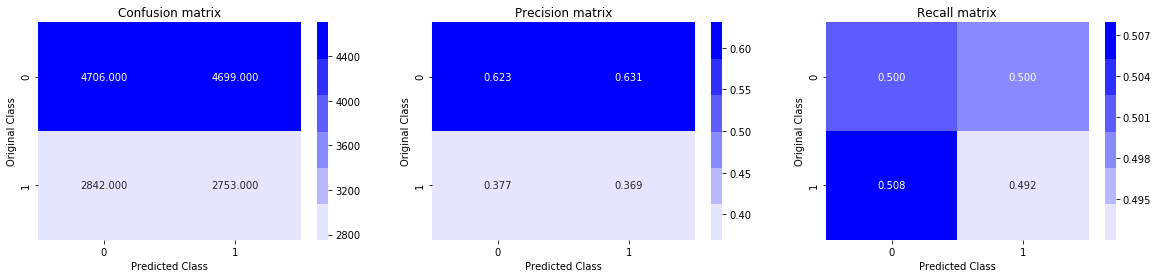

In [23]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# LOGISTIC REGRESSION

For values of alpha =  1e-05 The log loss is: 0.6586489466732767
For values of alpha =  0.0001 The log loss is: 0.6586489466732767
For values of alpha =  0.001 The log loss is: 0.6586489466732767
For values of alpha =  0.01 The log loss is: 0.614065123886705
For values of alpha =  0.1 The log loss is: 0.6144293652923921
For values of alpha =  1 The log loss is: 0.6586489466732767
For values of alpha =  10 The log loss is: 0.6574867280589907


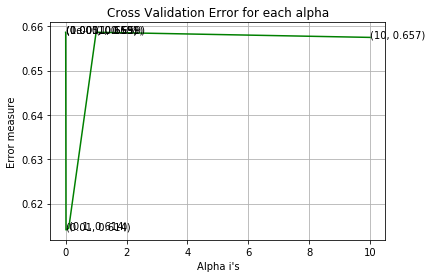

For values of best alpha =  0.01 The train log loss is: 0.6143797442084187
For values of best alpha =  0.01 The test log loss is: 0.614065123886705
Total number of data points : 120000


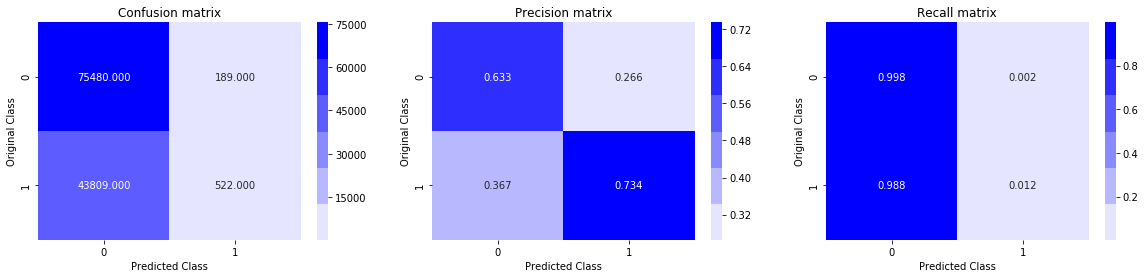

In [192]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [193]:
LogisticRegression_alpha = alpha[best_alpha]
LogisticRegression_logloss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

# LINEAR SVM

For values of alpha =  1e-05 The log loss is: 0.6586489466732767
For values of alpha =  0.0001 The log loss is: 0.6586489466732767
For values of alpha =  0.001 The log loss is: 0.6586489466732767
For values of alpha =  0.01 The log loss is: 0.6586489466732767
For values of alpha =  0.1 The log loss is: 0.61342744507318
For values of alpha =  1 The log loss is: 0.5886888763223536
For values of alpha =  10 The log loss is: 0.6474710342982285


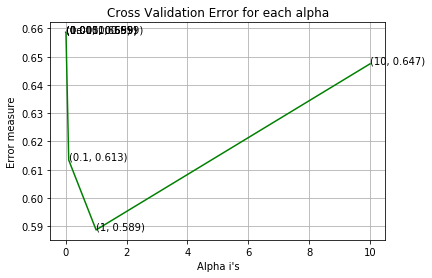

For values of best alpha =  1 The train log loss is: 0.5891724271157317
For values of best alpha =  1 The test log loss is: 0.5886888763223536
Total number of data points : 120000


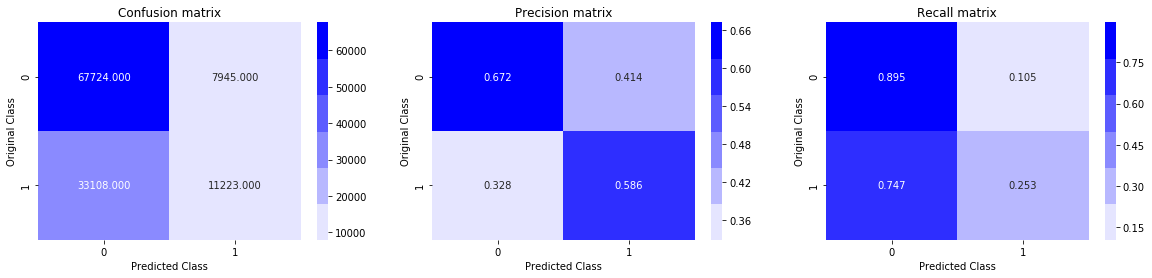

In [194]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [195]:
SVM_alpha = alpha[best_alpha]
SVM_logloss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

# SUMMARY

In [196]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter (ALPHA)", "LOG LOSS", "Data Points"]
x.add_row(["Tfidf", "Logistic Regression", LogisticRegression_alpha, LogisticRegression_logloss, rows])
x.add_row(["Tfidf", "Linear SVM", SVM_alpha, SVM_logloss, rows])
print(x)

+------------+---------------------+------------------------+--------------------+-------------+
| Vectorizer |        Model        | Hyperparameter (ALPHA) |      LOG LOSS      | Data Points |
+------------+---------------------+------------------------+--------------------+-------------+
|   Tfidf    | Logistic Regression |          0.01          | 0.614065123886705  |    400000   |
|   Tfidf    |      Linear SVM     |           1            | 0.5886888763223536 |    400000   |
+------------+---------------------+------------------------+--------------------+-------------+


## TFIDF weighted W2V (100k datapoints) gave better performance than TFIDF Vectorizer (400k datapoints).

In [25]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [26]:
import xgboost as xgb
import scipy.stats as stats
import time
from sklearn.model_selection import RandomizedSearchCV
# https://stackoverflow.com/a/43928043/7437264
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [0.5, 1, 2, 3, 4]
             }

numFolds = 3


clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 2,  
                         n_iter = 5, 
                         error_score = 0, 
                         verbose = 3, n_jobs=2)

print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train, y_train)

print("Randomized search time:", time.time() - search_time_start)



Randomized search..
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.2min finished


Randomized search time: 123.22593903541565


In [27]:
# https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d
best_score = clf.best_score_
best_params = clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print(param_name, best_params[param_name])

Best score: 0.8103142857142858
Best params: 
colsample_bytree 0.9029922176434346
learning_rate 0.32040976008486494
max_depth 3
min_child_weight 0.5
n_estimators 666
subsample 0.9568731002649842


In [28]:

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.32040976008486494
params['max_depth'] = 3
params['n_estimators'] = 666
params['subsample'] = 0.9568731002649842
params['colsample_bytree'] = 0.9029922176434346
params['min_child_weight'] = 0.5

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.591281	valid-logloss:0.591067
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.394402	valid-logloss:0.393142
[20]	train-logloss:0.371096	valid-logloss:0.370797
[30]	train-logloss:0.359017	valid-logloss:0.360802
[40]	train-logloss:0.351053	valid-logloss:0.354834
[50]	train-logloss:0.345631	valid-logloss:0.351162
[60]	train-logloss:0.341341	valid-logloss:0.348741
[70]	train-logloss:0.336414	valid-logloss:0.346914
[80]	train-logloss:0.333304	valid-logloss:0.346495
[90]	train-logloss:0.330377	valid-logloss:0.345053
[100]	train-logloss:0.327015	valid-logloss:0.344643
[110]	train-logloss:0.324703	valid-logloss:0.344128
[120]	train-logloss:0.322531	valid-logloss:0.343966
[130]	train-logloss:0.320784	valid-logloss:0.343974
[140]	train-logloss:0.318587	valid-logloss:0.34378
[150]	train-logloss:0.316247	valid-logloss:0.343465
[160]	train-logloss:0.314416	

Total number of data points : 15000


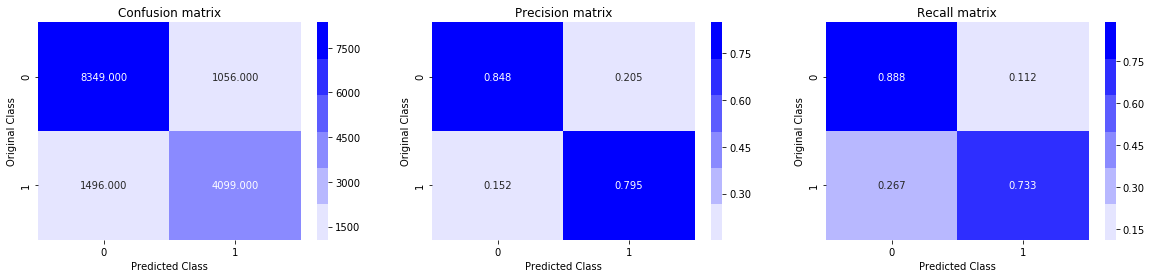

In [29]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)